# Spam classification

# 1. Get the data

In [5]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
SPAM_NAMES = ['20030228_spam.tar.bz2', '20030228_spam_2.tar.bz2', '20050311_spam_2.tar.bz2', '20021010_spam.tar.bz2']
HAM_NAMES = ['20021010_easy_ham.tar.bz2', '20021010_hard_ham.tar.bz2', '20030228_easy_ham.tar.bz2', '20030228_easy_ham.tar.bz2']
DATA_PATH = os.path.join('datasets', 'spam')

def fetch_spam_data():
    os.makedirs(DATA_PATH, exist_ok=True)
    for spam_file in SPAM_NAMES:
        spam_path = os.path.join(DATA_PATH, spam_file)
        spam_url = os.path.join(DOWNLOAD_ROOT, spam_file)
        urllib.request.urlretrieve(spam_url, spam_path)
        tgz = tarfile.open(spam_path)
        tgz.extractall(path=os.path.join(DATA_PATH, 'spam'))
        tgz.close()
    for ham_file in HAM_NAMES:
        ham_path = os.path.join(DATA_PATH, ham_file)
        ham_url = os.path.join(DOWNLOAD_ROOT, ham_file)
        urllib.request.urlretrieve(ham_url, ham_path)
        tgz = tarfile.open(ham_path)
        tgz.extractall(path=os.path.join(DATA_PATH, 'ham'))
        tgz.close()

In [6]:
fetch_spam_data()

# 2. Creating a pandas dataframe

In [37]:
import pandas as pd
import numpy as np
import glob

def label_data(path, label):
    data = []
    for filename in glob.iglob(os.path.join(path, '**/**'), recursive=True):
        if not os.path.isdir(filename):
            # some strange file sometimes occuring
            if not filename[-4:] == 'cmds':
                data.append([filename, label])
    return data

In [39]:
spamdata = label_data(os.path.join(DATA_PATH, 'spam'), label=1)
hamdata = label_data(os.path.join(DATA_PATH, 'ham'), label=0)

In [40]:
dataset = pd.DataFrame(data=[*spamdata, *hamdata], columns=['Filepath', 'Cat'])

In [41]:
dataset.head()

,Filepath,Cat
0,datasets\spam\spam\spam\0000.7b1b73cf36cf9dbc3...,1
1,datasets\spam\spam\spam\00001.7848dde101aa9850...,1
2,datasets\spam\spam\spam\00002.d94f1b97e48ed3b5...,1
3,datasets\spam\spam\spam\00003.2ee33bc6eacdb11f...,1
4,datasets\spam\spam\spam\00004.eac8de8d759b7e74...,1


<br> Let's save the file as csv to restore it in the future. <br><br>

In [42]:
dataset.to_csv(os.path.join(DATA_PATH, 'dataset.csv'), index=False)

# 3. Create train/test split

In [45]:
import pandas as pd

dataset = pd.read_csv(os.path.join(DATA_PATH, 'dataset.csv'))
dataset.head()

,Filepath,Cat
0,datasets\spam\spam\spam\0000.7b1b73cf36cf9dbc3...,1
1,datasets\spam\spam\spam\00001.7848dde101aa9850...,1
2,datasets\spam\spam\spam\00002.d94f1b97e48ed3b5...,1
3,datasets\spam\spam\spam\00003.2ee33bc6eacdb11f...,1
4,datasets\spam\spam\spam\00004.eac8de8d759b7e74...,1


In [48]:
from sklearn.model_selection import train_test_split

y = dataset["Cat"].copy()
X = dataset.drop("Cat", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X_train

,Filepath
424,datasets\spam\spam\spam\00386.6074f269f0bd1aec...
554,datasets\spam\spam\spam\0054.839a9c0a07f137185...
2992,datasets\spam\spam\spam\0094.3ba780eac7dce1c2b...
1954,datasets\spam\spam\spam_2\00957.ffe295aaf7f975...
13884,datasets\spam\ham\easy_ham\1288.9235f568fa35fd...
...,...
5191,datasets\spam\ham\easy_ham\00360.5e45677c7b7a6...
13418,datasets\spam\ham\easy_ham\0822.3ebf2e0f82aa01...
5390,datasets\spam\ham\easy_ham\00541.cbdcefd1a6109...
860,datasets\spam\spam\spam\0360.5f5fc66c831d84570...


In [50]:
y_train

424      1
554      1
2992     1
1954     1
13884    0
        ..
5191     0
13418    0
5390     0
860      1
7270     0
Name: Cat, Length: 12318, dtype: int64

# 4. Data exploration

In [54]:
exploration_set = pd.concat([X_train, y_train], axis=1)

In [55]:
exploration_set.head()

,Filepath,Cat
424,datasets\spam\spam\spam\00386.6074f269f0bd1aec...,1
554,datasets\spam\spam\spam\0054.839a9c0a07f137185...,1
2992,datasets\spam\spam\spam\0094.3ba780eac7dce1c2b...,1
1954,datasets\spam\spam\spam_2\00957.ffe295aaf7f975...,1
13884,datasets\spam\ham\easy_ham\1288.9235f568fa35fd...,0


In [56]:
exploration_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12318 entries, 424 to 7270
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  12318 non-null  object
 1   Cat       12318 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 288.7+ KB


In [57]:
exploration_set.describe()

,Cat
count,12318.000000
mean,0.309547
std,0.462326
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<AxesSubplot:>

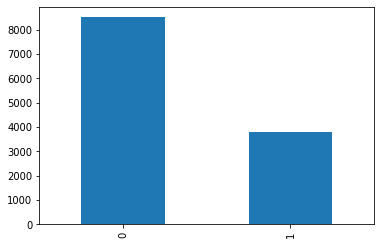

In [60]:
exploration_set['Cat'].value_counts().plot(kind='bar')

In [61]:
counts = exploration_set['Cat'].value_counts()
percentage = counts[1] / np.sum(counts)
print(f'Spam percentage {percentage}')

Spam percentage 0.30954700438382854


<br> From the [README file](https://spamassassin.apache.org/old/publiccorpus/readme.html) we can get that the percentage of spam is 31%, so our split got that right <br><br>